# EGFxSet: numerical and visual analysis

In [1]:
import sys
sys.path.append('../')

import os
import random
import numpy as np
import pandas as pd
import torch
import soundfile as sf
import essentia
import essentia.standard as es
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from src.data.egfxset import load_egfxset

In [2]:
# Setting up the directories and the sample rate

DATA_DIR = Path('../data/raw/')
MODELS_DIR = Path('../models/')
RESULTS_DIR = Path('../data/features/')
PLOTS_DIR = Path('../plots/')

sample_rate = 48000

In [3]:
seed = 42  # You can choose any seed value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
dry_samples_path = os.path.join(DATA_DIR, "egfxset/Clean")
wet_samples_path = os.path.join(DATA_DIR, "egfxset/Spring Reverb")

def compute_stats_of_file(data):
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    std_val = np.std(data)
    return min_val, max_val, mean_val, std_val

def load_and_analyze_files_from_dir(directory):
    global_audio_list = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                
                # Load audio using essentia MonoLoader
                audio, _ = sf.read(file_path)
                
                # Compute and print stats for this file
                stats = compute_stats_of_file(audio)
                # print(f"{file}: Min: {stats[0]:.3f}, Max: {stats[1]:.3f}, Mean: {stats[2]:.3f}, Std: {stats[3]:.3f}")
                
                # Add audio data to global list
                global_audio_list.append(audio)
                
    # Compute the stats for the entire dataset from this directory
    all_data = np.concatenate(global_audio_list)
    global_stats = compute_stats_of_file(all_data)
    print(f"\nGlobal for {directory}: Min: {global_stats[0]:.3f}, Max: {global_stats[1]:.3f}, Mean: {global_stats[2]:.3f}, Std: {global_stats[3]:.3f}\n")
    print(f"Number of files: {len(global_audio_list)}")
    
    return global_audio_list


In [5]:
print("Stats for Dry Samples:")
dry_samples = load_and_analyze_files_from_dir(dry_samples_path)

Stats for Dry Samples:

Global for ../data/raw/egfxset/Clean: Min: -1.000, Max: 1.000, Mean: 0.000, Std: 0.093

Number of files: 690


In [6]:
print("Stats for Wet Samples:")
dry_samples = load_and_analyze_files_from_dir(wet_samples_path)

Stats for Wet Samples:

Global for ../data/raw/egfxset/Spring Reverb: Min: -0.891, Max: 0.899, Mean: -0.000, Std: 0.100

Number of files: 690


In [7]:
train_loader, valid_loader, test_loader = load_egfxset(datadir=DATA_DIR, batch_size=1, train_ratio=0.5, valid_ratio=0.25, test_ratio=0.25)

len(train_loader), len(valid_loader), len(test_loader)

(346, 172, 172)

In [8]:
def compute_dataset_details(loader, sample_rate):
    # Number of samples
    num_samples = len(loader.dataset)

    # Compute total duration
    # Assuming each item in the dataset returns a tuple (audio, label) and audio is a 1D tensor
    total_samples_in_dataset = sum([len(audio[0]) for audio, _ in loader.dataset])
    samples_to_sec = total_samples_in_dataset / sample_rate
    minutes = samples_to_sec // 60
    seconds = samples_to_sec % 60
    total_duration = f"{minutes:.0f}'{seconds:.0f}''"

    # Compute total size in MB
    # Assuming float32 audio representation; 4 bytes per float
    total_size_bytes = total_samples_in_dataset * 4
    total_size_mb = total_size_bytes / (1024 * 1024)

    return num_samples, total_duration, total_size_mb

train_samples, train_duration, train_size_mb = compute_dataset_details(train_loader, sample_rate=sample_rate)
val_samples, val_duration, val_size_mb = compute_dataset_details(valid_loader, sample_rate=sample_rate)
test_samples, test_duration, test_size_mb = compute_dataset_details(test_loader, sample_rate=sample_rate)

print(f"Training Data: {train_samples} samples, {train_duration}, {train_size_mb} MB")
print(f"Validation Data: {val_samples} samples, {val_duration}, {val_size_mb} MB")
print(f"Test Data: {test_samples} samples, {test_duration}, {test_size_mb} MB")

Training Data: 346 samples, 28'50'', 316.7724609375 MB
Validation Data: 172 samples, 14'20'', 157.470703125 MB
Test Data: 172 samples, 14'20'', 157.470703125 MB


In [9]:
# NumPy Stats

def compute_stats(loader):
    min_vals_dry, max_vals_dry, mean_vals_dry, std_devs_dry = [], [], [], []
    min_vals_wet, max_vals_wet, mean_vals_wet, std_devs_wet = [], [], [], []
    
    for dry_sample, wet_sample in loader:
        min_vals_dry.append(torch.min(dry_sample).item())
        max_vals_dry.append(torch.max(dry_sample).item())
        mean_vals_dry.append(torch.mean(dry_sample).item())
        std_devs_dry.append(torch.std(dry_sample).item())

        min_vals_wet.append(torch.min(wet_sample).item())
        max_vals_wet.append(torch.max(wet_sample).item())
        mean_vals_wet.append(torch.mean(wet_sample).item())
        std_devs_wet.append(torch.std(wet_sample).item())

    stats = {
        "dry": {
            "min": min(min_vals_dry),
            "max": max(max_vals_dry),
            "mean": np.mean(mean_vals_dry),
            "std_dev": np.mean(std_devs_dry),
        },
        "wet": {
            "min": min(min_vals_wet),
            "max": max(max_vals_wet),
            "mean": np.mean(mean_vals_wet),
            "std_dev": np.mean(std_devs_wet),
        },
    }

    return stats

for split in [train_loader, valid_loader, test_loader]:
    stats = compute_stats(split)
    
    for s in stats:
        for k, v in stats[s].items():
            print(f"{s} {k}: {v:.4f}") 

dry min: -1.0000
dry max: 1.0000
dry mean: -0.0000
dry std_dev: 0.0943
wet min: -1.0000
wet max: 1.0000
wet mean: -0.0000
wet std_dev: 0.1050
dry min: -1.0000
dry max: 1.0000
dry mean: -0.0000
dry std_dev: 0.0929
wet min: -1.0000
wet max: 1.0000
wet mean: -0.0000
wet std_dev: 0.1024
dry min: -1.0000
dry max: 1.0000
dry mean: -0.0000
dry std_dev: 0.0943
wet min: -1.0000
wet max: 1.0000
wet mean: -0.0000
wet std_dev: 0.1032


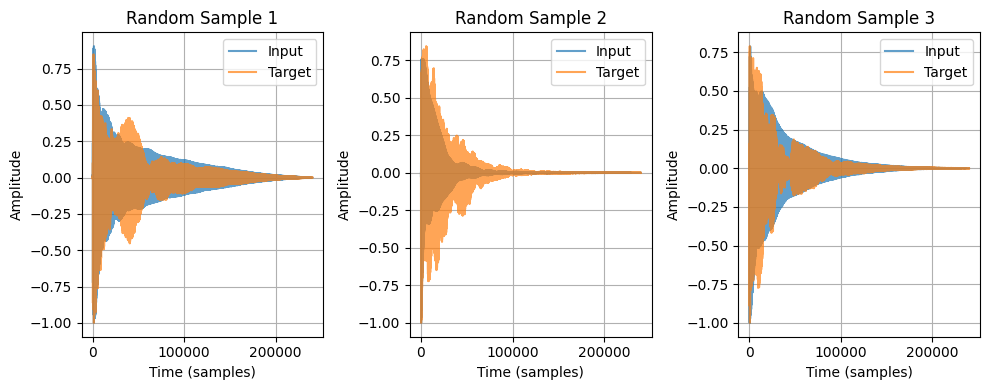

In [11]:
# Waveform

# Randomly select 5 batches
num_batches = len(train_loader)
random_sample_indices = random.sample(range(num_batches), 3)

desired_samples = []

# Extract desired samples
for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
    if batch_idx in random_sample_indices:
        # Assuming batch_size is 1, just select the first sample
        x = X_batch[0]
        y = Y_batch[0]
        desired_samples.append((x, y))

# Plot the extracted waveforms
fig, axs = plt.subplots(nrows=1, ncols=len(desired_samples), figsize=(10, 4))
for i, (x, y) in enumerate(desired_samples):
    axs[i].plot(x.squeeze().numpy(), alpha=0.7)
    axs[i].plot(y.squeeze().numpy(), alpha=0.7)
    axs[i].set_title(f'Random Sample {i + 1}')
    axs[i].set_xlabel('Time (samples)')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend(['Input', 'Target'])
    axs[i].grid(True)

plt.tight_layout()
plt.show()

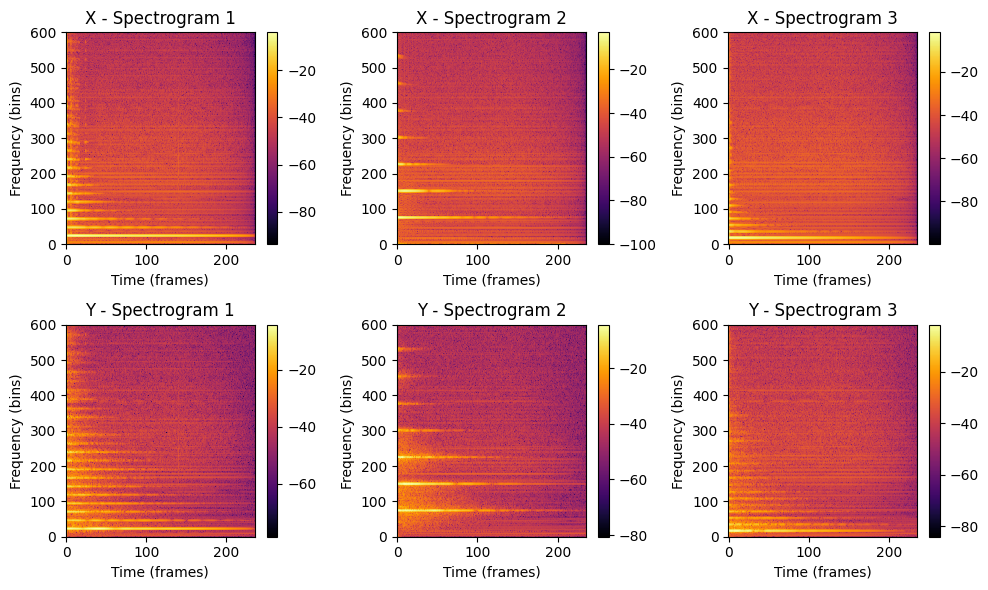

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=len(desired_samples), figsize=(10, 6))

# Setting sample rate and STFT parameters
frameSize = 2048  # STFT window size
hopSize =  1024   # Overlap is frameSize - hopSize

# Setting up essentia algorithms
spectrum = es.Spectrum()
windowing = es.Windowing(type='blackmanharris62', zeroPadding=frameSize)

amp2db = es.UnaryOperator(type='lin2db', scale=4)
pool = essentia.Pool()

for idx, (x, y) in enumerate(desired_samples):
    pool.clear()

    x = x.squeeze().numpy()  # Convert data to NumPy array
    y = y.squeeze().numpy()

    spectrograms_x = []
    spectrograms_y = []

    for frame_x, frame_y in zip(es.FrameGenerator(x, frameSize=frameSize, hopSize=hopSize),
                                es.FrameGenerator(y, frameSize=frameSize, hopSize=hopSize)):
        x_stft = spectrum(windowing(frame_x))
        y_stft = spectrum(windowing(frame_y))
        
        pool.add('spectrum_db_x', amp2db(x_stft))
        pool.add('spectrum_db_y', amp2db(y_stft))
        

    # Plotting the X spectrogram
    img_x = axs[0, idx].imshow(pool['spectrum_db_x'].T, aspect='auto', origin='lower', interpolation='none', cmap='inferno')
    axs[0, idx].set_title(f"X - Spectrogram {idx + 1}")
    axs[0, idx].set_ylabel('Frequency (bins)')
    axs[0, idx].set_xlabel('Time (frames)')
    axs[0, idx].set_ylim(0, 600)
    plt.colorbar(img_x, ax=axs[0, idx])  # Adding colorbar

    # Plotting the Y spectrogram
    img_y = axs[1, idx].imshow(pool['spectrum_db_y'].T, aspect='auto', origin='lower', interpolation='none', cmap='inferno')
    axs[1, idx].set_title(f"Y - Spectrogram {idx + 1}")
    axs[1, idx].set_ylabel('Frequency (bins)')
    axs[1, idx].set_xlabel('Time (frames)')
    axs[1, idx].set_ylim(0, 600)
    plt.colorbar(img_y, ax=axs[1, idx])

plt.tight_layout()
plt.show()